# Decision Trees

Decision trees helps making decisions using variables to classify content.<br>

Basically a tree is a list of arbitrary exigences. If you do respect it you continue on the rigth of the node, if you dont you continue on the left of it. It then helps you classify a content based on a number of parameters. Th emore complex the tree is the more parameters it will use and the more depth it will habe. But **be carefull not to make your trees overfit !** (or else you'll have to chopp them a bit) <br>

An example of a decition tree is You whand to find out which thype of annimal there is in front of you. Then you can have the following thougth process:
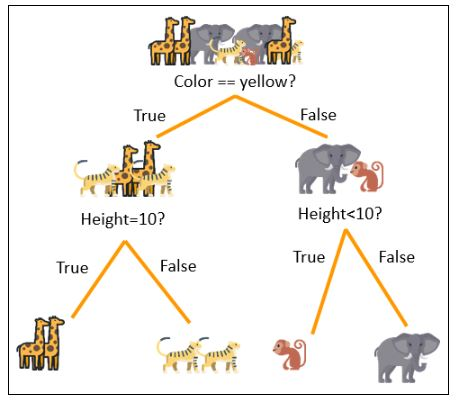<br>
Well this is a **decision tree** it leads you to classify annimals based on a number of features. At each node you see if the value of that annimal regarding a particular feature is above or below a certain threshold. Then you continue the tree untill you've narrowed it down enougth to make a decision.


Now here is an example of what a decision tree can look like with more abstract data:
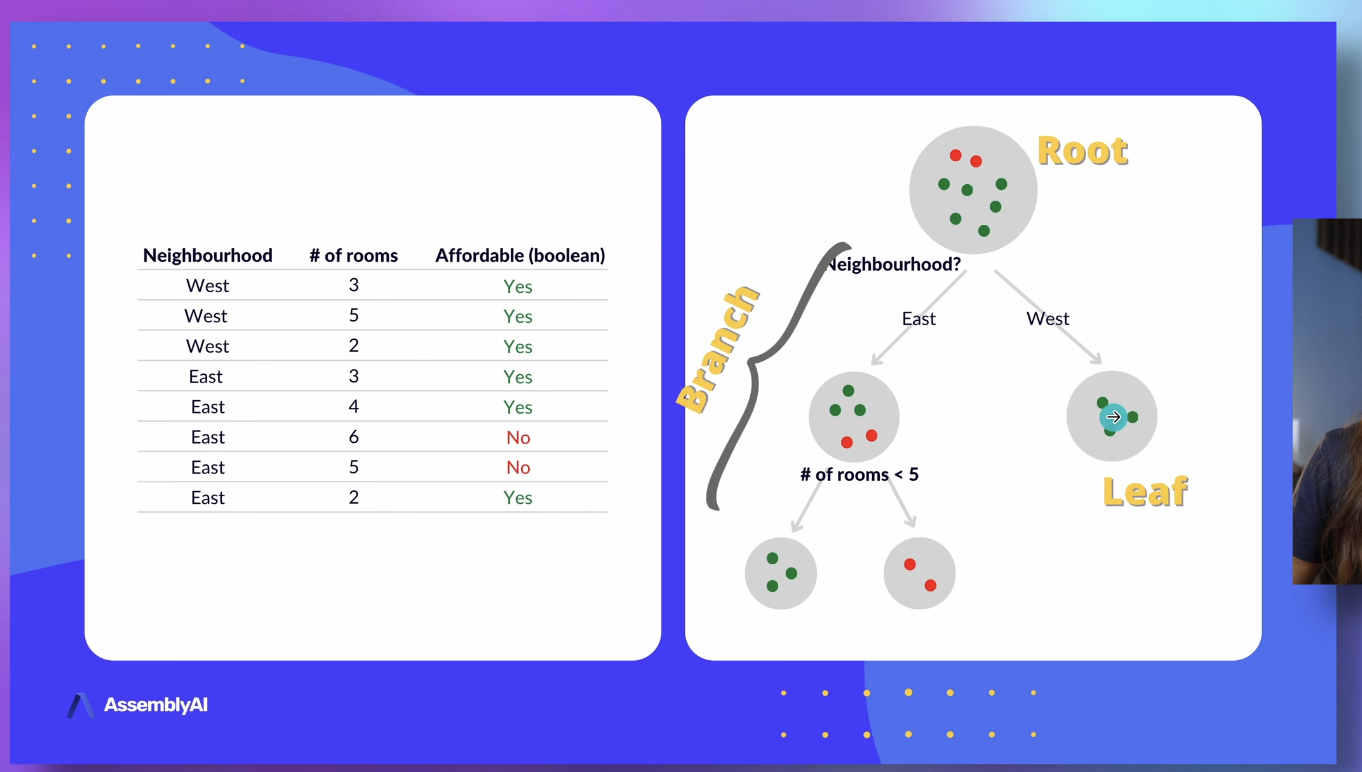
To create a decision tree we start from the top of it and continue creating nodes untill we've splitted the data perfectly or we've reach a predetermines _maximum depth_. Basically at each node we are trying to find the feature and threshold that maximizes the split between my different classes. To do so for each node we compute the Information gain of each feature and chose the one that brings the mose information to the tree.<br>

*Important formulas*:
* Information gain : $$IG = \mathbb{E}(parent)-[weighted \ average]-\mathbb{E}(children)$$

* Entropy $$ \mathbb{E} = - \sum{p(X)*log_2(p(X))}$$
    with : $$p(X) = \frac{\#x}{n}$$

* Stopping criteria: maximum depth, minimum number of samples, min impurity decrease

## Lets create a class for nodes and trees

To create a tree of nodes. We first find the feature and threashold that splits the best our dataset by calculating each possible Information gains. Then we make a node with that information and then continue the tree with the left and rigth side of that node. By continuing the tree we work with (all the other features that hasnt beed used yet. ) a random selection of features every time to improve efficiency and the possibility of having different features. 
$$$$
This goes on untill all the nodes are leaf nodes (leading to a perfect split without hesitation) or if the maximum depth of the tree is reached.

In [2]:
import numpy as np
from collections import Counter

In [2]:
class Node:
    def __init__(self,
                 feature = None,
                 threshold = None,
                 left = None,
                 rigth = None,
                 *, # only keyword arguments after this
                 value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.rigth = rigth
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y) 
        pass
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # Check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feat_idxs = np.random.choice(n_features, self.n_features, replace=False)
        
        # find the best split
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        
        # Ensure splits are not empty
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        rigth = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feat, best_thresh, left, rigth)
    
    def _most_common_label(self, y):
        #return np.bincount(y).argmax() #dont tolerate negatiev values
        return Counter(y).most_common(1)[0][0]
    
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh
    
    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_idxs, rigth_idxs = self._split(X_column, split_thresh)
        
        if len(left_idxs) == 0 or len(rigth_idxs) == 0:
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(rigth_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[rigth_idxs])
        
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def _split(self, X, split_thresh):
        left_idxs = np.argwhere(X <= split_thresh).flatten()
        rigth_idxs = np.argwhere(X > split_thresh).flatten()
        return left_idxs, rigth_idxs
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.rigth)

In [3]:
def display_Tree(node, depth=0):
    if node is None:
        return
    if node.is_leaf_node():
        print(f"{depth*'  '}Leaf Node: {node.value}")
        return
    print(f"{depth*'  '}Feature: {node.feature}, Threshold: {node.threshold}")
    display_Tree(node.left, depth+1)
    display_Tree(node.rigth, depth+1)

## Example of application

### Lets import our dataset

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('data/titanic_cleaned.csv')
df.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,1st_class,2nd_class,3rd_class,Embarked_S,Embarked_C,Embarked_Q
0,1,0,1,22,1,0,7.2500,0,0,1,1,0,0
1,2,1,0,38,1,0,71.2833,1,0,0,0,1,0
2,3,1,0,26,0,0,7.9250,0,0,1,1,0,0
3,4,1,0,35,1,0,53.1000,1,0,0,1,0,0
4,5,0,1,35,0,0,8.0500,0,0,1,1,0,0


In [6]:
y = df[["PassengerId", 'Survived']]
X = df.drop('Survived', axis=1)
y.head()

,PassengerId,Survived
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0


In [7]:
X.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,1st_class,2nd_class,3rd_class,Embarked_S,Embarked_C,Embarked_Q
0,1,1,22,1,0,7.2500,0,0,1,1,0,0
1,2,0,38,1,0,71.2833,1,0,0,0,1,0
2,3,0,26,0,0,7.9250,0,0,1,1,0,0
3,4,0,35,1,0,53.1000,1,0,0,1,0,0
4,5,1,35,0,0,8.0500,0,0,1,1,0,0


lets take the first 10 rows and make a decision tree

In [8]:
import matplotlib.pyplot as plt

In [9]:
X[:5].values[:, 1:].shape

(5, 11)

In [10]:
X_train, y_train = X[:5].values[:, 1:], y[:5].values[:, 1].flatten()

In [11]:
X_train.shape, y_train

((5, 11), array([0, 1, 1, 1, 0]))

Now lets create the decition tree

In [12]:
tree = DecisionTree(max_depth=5, n_features=2)
tree.fit(X_train, y_train)
display_Tree(tree.root)

Feature: 5, Threshold: 0.0
  Leaf Node: 0
  Leaf Node: 1


In [13]:
predictions = tree.predict(X_train)
predictions

array([0, 1, 0, 1, 0])

In [14]:
print(f"Accuracy: {np.mean(predictions == y_train) * 100:.2f}%")

Accuracy: 80.00%


## Random Forest

A tree is good but it has its limits, for a large or complex dataset one tree is too concrete to be able to generalise. Thats why we created the **Random Tree Forest**

<br>
The concept is simple:<br>
   - You create a lot of different trees <br>
   -  To make a decision you get the outputs out of each tree and the majority wins.<br>
   - For eample with a random forest of 100 trees and a dataset consisting of finding the survivors of the titanic given their Class, age ...
        If for a given passenger i have 55 'survived' and '45' dies. I will say that the passenger is likely to survive. (We can eather output 0 or 1 or the confidence score, here being 0.55)<br>
<br>

To ensure that each tree uses different features and splits the data using different techniques we use randomization twice. Thats why it is called a **random**  tree forest.<br>
   1) We split the dataset into smaller ones<br>
   2) when creating a tree we use a randomely selected number of features to ensure diversity.<br>
<br>

Hyperparameters are:<br>
   - The depth of the trees<br>
   - The number of trees<br>
   - The number of features allowed by tree<br>
<br>

Usually numbers such as the _square root_ or the _log_ of the number of features tends to work well for both efficiency and reliability.
<br>

**Notes**:
   - By taking the _mean_ of the outputs we can also solve regression problems using random forests

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   1st_class    891 non-null    int64  
 8   2nd_class    891 non-null    int64  
 9   3rd_class    891 non-null    int64  
 10  Embarked_S   891 non-null    int64  
 11  Embarked_C   891 non-null    int64  
 12  Embarked_Q   891 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 90.6 KB


In [16]:
class RandomForest:
    def __init__(self, n_trees=100, min_samples_split=2, max_depth=100, n_features=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.trees = []
        
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth, n_features=self.n_features)
            X_samp, y_samp = self._bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)
        
    def predict(self, X, choiceMethod='majority'):
        dictMethod = {
            'majority': self._most_common_label,
            'average': np.mean
        }
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [dictMethod[choiceMethod](tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)
    
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]
    
    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]
    

### Now lets try it out

In [17]:
np.log(X.shape[1])

2.4849066497880004

In [18]:
forest = RandomForest(n_trees=80, max_depth=10, n_features=3)

# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
X = df.drop(['Survived', "PassengerId"], axis=1).values
y = df['Survived'].values.flatten()

trainPercent = 0.8
trainSize = int(trainPercent * len(X))

X_train, y_train, X_test, y_test = X[:trainSize], y[:trainSize], X[trainSize:], y[trainSize:]

forest.fit(X_train, y_train)
len(forest.trees)

KeyboardInterrupt: 

In [ ]:
predictions = forest.predict(X_test)
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0])

In [ ]:
print(f"Accuracy: {np.mean(predictions == y_test) * 100:.2f}%")

Accuracy: 82.12%
